CELL 0 — Trial-5 
--
MIN_POINTS=7 | chi-square 99 % (df=3)
--
Per-frame preprocessing

ROI XY only

Soft SNR weights

K=1 Gaussian

Refit on inliers (offline)

Outputs Head 1–3 per trial per subject

Head-4 not enabled

CELL 1 — Imports + Global Seed

In [1]:
import os
import json
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import chi2

# Optional interactivity (VSCode Jupyter)
try:
    import ipywidgets as widgets
    from IPython.display import display
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
np.random.seed(SEED)


CELL 2 — Paths + Trial-2 Config (LOCKED)

In [2]:
# -------------------------
# Paths
# -------------------------
DATASET_ROOT = Path(r"E:\0.TA_Teguh\dataset3")   # contains A..J
OUT_ROOT     = Path(r"E:\0.TA_Teguh\GMM Trial 5")        # output root

SUBJECTS = list("ABCDEFGHIJ")  # A..J
TRIALS   = list(range(1, 73))  # Jalan1..Jalan72

# ===============================
# Trial-2 Configuration (LOCKED)
# ===============================

# ROI (NO Z GATING)
ROI_X = (-2.5, 2.5)
ROI_Y = (0.0, 5.0)

# Frame validity
MIN_POINTS = 7  # baseline (later try 10)

# Gaussian model
GMM_K = 1  # fixed: single Gaussian

# Mahalanobis outlier removal
CHI2_LEVEL = 0.99
CHI2_DF = 3  # x,y,z

# Refit (offline)
USE_REFIT_OFFLINE = True

# Soft SNR weighting (baseline)
SNR_REF = 10.0
SNR_WEIGHT_MIN = 0.10
SNR_WEIGHT_MAX = 1.00

# Numerical safety
COV_EPS = 1e-6


CELL 3 — Create Output Folders (Head 1/2/3 + per subject + _summary)

In [3]:
def ensure_dirs():
    for head_name in ["Head 1", "Head 2", "Head 3"]:
        (OUT_ROOT / head_name).mkdir(parents=True, exist_ok=True)
        (OUT_ROOT / head_name / "_summary").mkdir(parents=True, exist_ok=True)
        for s in SUBJECTS:
            (OUT_ROOT / head_name / s).mkdir(parents=True, exist_ok=True)

    (OUT_ROOT / "_summary").mkdir(parents=True, exist_ok=True)

ensure_dirs()
print("Output folders ready:", OUT_ROOT)


Output folders ready: E:\0.TA_Teguh\GMM Trial 5


CELL 4 — Build File Index + Missing Files Audit

In [4]:
def build_file_index() -> pd.DataFrame:
    rows = []
    for s in SUBJECTS:
        for t in TRIALS:
            in_path = DATASET_ROOT / s / f"Jalan{t}.csv"
            h1_out  = OUT_ROOT / "Head 1" / s / f"Jalan{t}.csv"
            h2_out  = OUT_ROOT / "Head 2" / s / f"Jalan{t}.csv"
            h3_out  = OUT_ROOT / "Head 3" / s / f"Jalan{t}.jsonl"
            rows.append({
                "subject": s,
                "trial": t,
                "input_path": str(in_path),
                "head1_out": str(h1_out),
                "head2_out": str(h2_out),
                "head3_out": str(h3_out),
            })
    return pd.DataFrame(rows)

index_df = build_file_index()

missing = index_df[~index_df["input_path"].apply(lambda p: Path(p).exists())]
print("Total index rows:", len(index_df))
print("Missing files:", len(missing))
if len(missing) > 0:
    display(missing.head(20) if HAS_WIDGETS else missing.head(20))


Total index rows: 720
Missing files: 0


CELL 5 — CSV Loader

In [5]:
REQUIRED_COLS = ["timestamp", "frame", "x", "y", "z", "doppler", "SNR"]

def load_trial_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    for c in REQUIRED_COLS:
        if c not in df.columns:
            raise ValueError(f"Missing column '{c}' in {path}")

    # types
    df["timestamp"] = df["timestamp"].astype(str)
    df["frame"] = df["frame"].astype(int)
    for c in ["x", "y", "z", "doppler", "SNR"]:
        df[c] = df[c].astype(float)

    df = df.sort_values(["frame"]).reset_index(drop=True)
    return df


CELL 6 — Utility: JSON-safe converter 

In [6]:
def to_py(obj):
    """Convert numpy scalars/arrays to Python native types for JSON serialization."""
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: to_py(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_py(v) for v in obj]
    return obj


CELL 7 — Core Math: Soft SNR Weight, Fit K=1 Gaussian, Mahalanobis d²

In [7]:
def compute_snr_weight(snr_values: np.ndarray) -> np.ndarray:
    """
    Soft weighting: higher SNR => higher weight, clipped.
    Baseline: w = clip(SNR / SNR_REF, [min, max])
    """
    snr_values = np.asarray(snr_values, dtype=float)
    w = snr_values / float(SNR_REF)
    w = np.clip(w, SNR_WEIGHT_MIN, SNR_WEIGHT_MAX)
    return w

def fit_gaussian_k1(X: np.ndarray, weights: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Weighted Gaussian fit (K=1): returns (mu[3], Sigma[3x3]).
    """
    X = np.asarray(X, dtype=float)
    if X.ndim != 2 or X.shape[1] != 3:
        raise ValueError("X must be shape (N,3)")

    if weights is None:
        mu = X.mean(axis=0)
        Sigma = np.cov(X.T, bias=False)
    else:
        w = np.asarray(weights, dtype=float)
        w = w / (np.sum(w) + 1e-12)
        mu = np.sum(X * w[:, None], axis=0)
        Xc = X - mu
        Sigma = (Xc.T * w) @ Xc

    # numerical safety
    Sigma = np.asarray(Sigma, dtype=float)
    Sigma += COV_EPS * np.eye(3)
    return mu, Sigma

def mahalanobis_d2(X: np.ndarray, mu: np.ndarray, Sigma: np.ndarray) -> np.ndarray:
    """
    Returns Mahalanobis squared distance d² for each point in X.
    """
    X = np.asarray(X, dtype=float)
    mu = np.asarray(mu, dtype=float)
    Sigma = np.asarray(Sigma, dtype=float)

    invS = np.linalg.inv(Sigma)
    diff = X - mu
    d2 = np.einsum("ij,jk,ik->i", diff, invS, diff)
    return d2

def chi2_threshold(level: float, df: int = 3) -> float:
    return float(chi2.ppf(level, df=df))


CELL 8 — Per-frame Processor (Trial-2 rules)

In [8]:
def process_frame(df_frame: pd.DataFrame) -> Tuple[pd.DataFrame, Dict, Optional[Dict]]:
    """
    Input: df_frame = rows for one frame (raw points).
    Output:
      - df_h1: Head-1 rows for this frame (inliers only; may be empty)
      - row_h2: Head-2 summary row (always returned)
      - row_h3: Head-3 params row (only if valid and GMM executed; else None)
    """
    frame_id = int(df_frame["frame"].iloc[0])
    ts = str(df_frame["timestamp"].iloc[0])

    # ROI gating (x,y only)
    df_roi = df_frame[
        df_frame["x"].between(*ROI_X) &
        df_frame["y"].between(*ROI_Y)
    ].copy()

    N_raw = int(len(df_frame))
    N_roi = int(len(df_roi))

    # Head-2 row (always)
    row_h2 = {
        "timestamp": ts,
        "frame": frame_id,
        "N_raw": N_raw,
        "N_roi": N_roi,
        "valid_minpts": 0,
        "N_inlier": 0,
        "conf": 0.0,
    }

    # invalid by min points
    if N_roi < MIN_POINTS:
        return pd.DataFrame(), row_h2, None

    row_h2["valid_minpts"] = 1

    # Prepare for Gaussian fit
    X = df_roi[["x", "y", "z"]].values
    snr = df_roi["SNR"].values
    w_snr = compute_snr_weight(snr)

    # Fit initial Gaussian
    mu, Sigma = fit_gaussian_k1(X, w_snr)
    d2 = mahalanobis_d2(X, mu, Sigma)
    thr = chi2_threshold(CHI2_LEVEL, df=CHI2_DF)

    inlier_mask = d2 <= thr
    df_in = df_roi.loc[inlier_mask].copy()

    # Add audit columns
    df_in["w_snr"] = w_snr[inlier_mask]
    df_in["d2"] = d2[inlier_mask]
    df_in["is_inlier"] = 1

    N_in = int(len(df_in))
    row_h2["N_inlier"] = N_in
    row_h2["conf"] = float(N_in / max(N_roi, 1))

    # If inliers too few, treat as invalid for Head-1/3 (Opsi A)
    if N_in < MIN_POINTS:
        row_h2["valid_minpts"] = 0
        row_h2["conf"] = 0.0
        return pd.DataFrame(), row_h2, None

    # Optional refit on inliers (OFFLINE)
    if USE_REFIT_OFFLINE:
        X_in = df_in[["x", "y", "z"]].values
        w_in = df_in["w_snr"].values
        mu, Sigma = fit_gaussian_k1(X_in, w_in)

    # Head-3 row (valid only)
    row_h3 = {
        "timestamp": ts,
        "frame": frame_id,
        "mu": mu.tolist(),
        "Sigma": Sigma.tolist(),
        "chi2_level": float(CHI2_LEVEL),
        "chi2_df": int(CHI2_DF),
        "chi2_threshold": float(thr),
        "N_raw": int(N_raw),
        "N_roi": int(N_roi),
        "N_inlier": int(N_in),
        "refit": bool(USE_REFIT_OFFLINE),
    }

    return df_in, row_h2, row_h3


CELL 9 — Per-file Processor (saves Head 1/2/3 per trial)

In [9]:
def process_one_file(input_path: str, head1_out: str, head2_out: str, head3_out: str) -> Dict:
    df = load_trial_csv(input_path)

    frames = sorted(df["frame"].unique().tolist())

    h1_parts: List[pd.DataFrame] = []
    h2_rows: List[Dict] = []
    h3_rows: List[Dict] = []

    points_before = int(len(df))

    for f in frames:
        df_f = df[df["frame"] == f]
        df_h1, row_h2, row_h3 = process_frame(df_f)

        # Head-2 always
        h2_rows.append(row_h2)

        # Head-1 only if any
        if not df_h1.empty:
            h1_parts.append(df_h1)

        # Head-3 only if valid
        if row_h3 is not None:
            h3_rows.append(row_h3)

    # Save Head-1
    if len(h1_parts) > 0:
        h1_df = pd.concat(h1_parts, ignore_index=True)
        # ensure column order (optional but nice)
        cols = ["timestamp","frame","x","y","z","doppler","SNR","w_snr","d2","is_inlier"]
        cols = [c for c in cols if c in h1_df.columns]
        h1_df = h1_df[cols]
        h1_df.to_csv(head1_out, index=False)
        points_after = int(len(h1_df))
    else:
        pd.DataFrame(columns=["timestamp","frame","x","y","z","doppler","SNR","w_snr","d2","is_inlier"]).to_csv(head1_out, index=False)
        points_after = 0

    # Save Head-2
    h2_df = pd.DataFrame(h2_rows)
    h2_cols = ["timestamp","frame","N_raw","N_roi","valid_minpts","N_inlier","conf"]
    h2_cols = [c for c in h2_cols if c in h2_df.columns]
    h2_df = h2_df[h2_cols]
    h2_df.to_csv(head2_out, index=False)

    # Save Head-3 (JSONL)
    with open(head3_out, "w", encoding="utf-8") as f:
        for r in h3_rows:
            f.write(json.dumps(to_py(r)) + "\n")

    frames_total = int(len(frames))
    frames_invalid = int((h2_df["valid_minpts"] == 0).sum()) if "valid_minpts" in h2_df.columns else 0
    mean_conf = float(h2_df["conf"].mean()) if "conf" in h2_df.columns and len(h2_df) else 0.0
    min_conf = float(h2_df["conf"].min()) if "conf" in h2_df.columns and len(h2_df) else 0.0

    return {
        "input_path": input_path,
        "points_before": points_before,
        "points_after": points_after,
        "frames_total": frames_total,
        "frames_invalid": frames_invalid,
        "mean_conf": mean_conf,
        "min_conf": min_conf,
    }


CELL 10 — Batch Runner (process all subjects + trials, skip missing)

In [10]:
def run_batch(index_df: pd.DataFrame) -> pd.DataFrame:
    rows = index_df.copy()

    summaries = []
    total = len(rows)

    for i, row in rows.reset_index(drop=True).iterrows():
        s = row["subject"]
        t = int(row["trial"])
        in_path = row["input_path"]

        print(f"[{i+1}/{total}] Processing {s}/Jalan{t} ...")

        if not Path(in_path).exists():
            summaries.append({
                "subject": s,
                "trial": t,
                "input_path": in_path,
                "error": "missing_file"
            })
            continue

        try:
            summ = process_one_file(
                input_path=in_path,
                head1_out=row["head1_out"],
                head2_out=row["head2_out"],
                head3_out=row["head3_out"]
            )
            summ["subject"] = s
            summ["trial"] = t
            summaries.append(summ)
        except Exception as e:
            summaries.append({
                "subject": s,
                "trial": t,
                "input_path": in_path,
                "error": str(e)
            })

    return pd.DataFrame(summaries)

summaries_df = run_batch(index_df)
display(summaries_df.head(10) if HAS_WIDGETS else summaries_df.head(10))


[1/720] Processing A/Jalan1 ...
[2/720] Processing A/Jalan2 ...
[3/720] Processing A/Jalan3 ...
[4/720] Processing A/Jalan4 ...
[5/720] Processing A/Jalan5 ...
[6/720] Processing A/Jalan6 ...
[7/720] Processing A/Jalan7 ...
[8/720] Processing A/Jalan8 ...
[9/720] Processing A/Jalan9 ...
[10/720] Processing A/Jalan10 ...
[11/720] Processing A/Jalan11 ...
[12/720] Processing A/Jalan12 ...
[13/720] Processing A/Jalan13 ...
[14/720] Processing A/Jalan14 ...
[15/720] Processing A/Jalan15 ...
[16/720] Processing A/Jalan16 ...
[17/720] Processing A/Jalan17 ...
[18/720] Processing A/Jalan18 ...
[19/720] Processing A/Jalan19 ...
[20/720] Processing A/Jalan20 ...
[21/720] Processing A/Jalan21 ...
[22/720] Processing A/Jalan22 ...
[23/720] Processing A/Jalan23 ...
[24/720] Processing A/Jalan24 ...
[25/720] Processing A/Jalan25 ...
[26/720] Processing A/Jalan26 ...
[27/720] Processing A/Jalan27 ...
[28/720] Processing A/Jalan28 ...
[29/720] Processing A/Jalan29 ...
[30/720] Processing A/Jalan30 ..

,input_path,points_before,points_after,frames_total,frames_invalid,mean_conf,min_conf,subject,trial
0,E:\0.TA_Teguh\dataset3\A\Jalan1.csv,3083,2659,111,34,0.673757,0.0,A,1
1,E:\0.TA_Teguh\dataset3\A\Jalan2.csv,6582,5418,113,31,0.698384,0.0,A,2
2,E:\0.TA_Teguh\dataset3\A\Jalan3.csv,6634,5859,119,34,0.690221,0.0,A,3
3,E:\0.TA_Teguh\dataset3\A\Jalan4.csv,2278,1670,96,47,0.500204,0.0,A,4
4,E:\0.TA_Teguh\dataset3\A\Jalan5.csv,2191,1236,127,70,0.434975,0.0,A,5
5,E:\0.TA_Teguh\dataset3\A\Jalan6.csv,3492,2195,127,63,0.488221,0.0,A,6
6,E:\0.TA_Teguh\dataset3\A\Jalan7.csv,4143,3244,118,41,0.630092,0.0,A,7
7,E:\0.TA_Teguh\dataset3\A\Jalan8.csv,2944,2801,74,21,0.693794,0.0,A,8
8,E:\0.TA_Teguh\dataset3\A\Jalan9.csv,2540,2000,123,58,0.508653,0.0,A,9
9,E:\0.TA_Teguh\dataset3\A\Jalan10.csv,4160,3637,131,53,0.573372,0.0,A,10


CELL 11 — Save Summaries (per subject + global)

In [11]:
def save_summaries(summaries_df: pd.DataFrame):
    # per subject summary (saved under each head _summary, same content)
    for head in ["Head 1", "Head 2", "Head 3"]:
        sum_dir = OUT_ROOT / head / "_summary"
        for s in SUBJECTS:
            sub = summaries_df[summaries_df["subject"] == s].copy()
            if len(sub) == 0:
                continue
            out = sum_dir / f"summary_{s}.csv"
            sub.to_csv(out, index=False)

    # global
    summaries_df.to_csv(OUT_ROOT / "_summary" / "global_summary.csv", index=False)

save_summaries(summaries_df)
print("Summaries saved to:", OUT_ROOT / "_summary")


Summaries saved to: E:\0.TA_Teguh\GMM Trial 5\_summary


VISUALIZATION CELLS

CELL 12 — Loader for Head outputs (one subject+trial)

In [12]:
def load_head_outputs(subject: str, trial: int):
    h1_path = OUT_ROOT / "Head 1" / subject / f"Jalan{trial}.csv"
    h2_path = OUT_ROOT / "Head 2" / subject / f"Jalan{trial}.csv"
    h3_path = OUT_ROOT / "Head 3" / subject / f"Jalan{trial}.jsonl"

    h1 = pd.read_csv(h1_path) if h1_path.exists() else pd.DataFrame()
    h2 = pd.read_csv(h2_path) if h2_path.exists() else pd.DataFrame()

    # jsonl
    h3_rows = []
    if h3_path.exists():
        with open(h3_path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                h3_rows.append(json.loads(line))
    h3 = pd.DataFrame(h3_rows)

    # types
    if len(h1) and "frame" in h1.columns:
        h1["frame"] = h1["frame"].astype(int)
    if len(h2) and "frame" in h2.columns:
        h2["frame"] = h2["frame"].astype(int)
    if len(h3) and "frame" in h3.columns:
        h3["frame"] = h3["frame"].astype(int)

    return h1, h2, h3


CELL 13 — Helper: Covariance → 2D ellipse params

In [13]:
from matplotlib.patches import Ellipse

def cov_to_ellipse_params_2d(S2: np.ndarray, n_std: float = 2.0):
    S2 = np.asarray(S2, dtype=float)
    vals, vecs = np.linalg.eigh(S2)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    width  = 2 * n_std * np.sqrt(max(vals[0], 0))
    height = 2 * n_std * np.sqrt(max(vals[1], 0))
    return width, height, angle


CELL 14 — Frame Viewer (A+B+C+D in one tidy view)

In [14]:
def visualize_frame(subject="A", trial=1, frame_id=None, n_std=2.0, max_points=1500):
    h1, h2, h3 = load_head_outputs(subject, trial)

    if len(h2) == 0:
        print("Head-2 empty / missing.")
        return

    frames_all = sorted(h2["frame"].unique().tolist())
    if frame_id is None:
        frame_id = frames_all[0]

    # Head-2 row
    row2 = h2[h2["frame"] == frame_id].iloc[0].to_dict()

    # Head-1 inliers
    f1 = h1[h1["frame"] == frame_id].copy() if len(h1) else pd.DataFrame()

    # For "raw vs inlier", we need raw points from original CSV
    raw_path = DATASET_ROOT / subject / f"Jalan{trial}.csv"
    df_raw = load_trial_csv(str(raw_path))
    fraw = df_raw[df_raw["frame"] == frame_id].copy()

    # downsample for plotting
    if len(fraw) > max_points:
        fraw = fraw.sample(max_points, random_state=SEED)
    if len(f1) > max_points:
        f1 = f1.sample(max_points, random_state=SEED)

    # Head-3 params for this frame (if exists)
    row3 = None
    if len(h3) and (h3["frame"] == frame_id).any():
        row3 = h3[h3["frame"] == frame_id].iloc[0].to_dict()

    fig = plt.figure(figsize=(15, 10))

    # --- A: XY scatter (inliers) + ellipse
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title("A) XY Inliers + Gaussian ellipse")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_xlim(ROI_X[0], ROI_X[1])
    ax1.set_ylim(ROI_Y[0], ROI_Y[1])

    if len(f1):
        if "d2" in f1.columns:
            ax1.scatter(f1["x"], f1["y"], s=8, c=f1["d2"])
        else:
            ax1.scatter(f1["x"], f1["y"], s=8)

    if row3 is not None:
        mu = np.array(row3["mu"], dtype=float)
        Sigma = np.array(row3["Sigma"], dtype=float)
        Sxy = Sigma[np.ix_([0,1],[0,1])]
        w, h, ang = cov_to_ellipse_params_2d(Sxy, n_std=n_std)
        ax1.add_patch(Ellipse((mu[0], mu[1]), width=w, height=h, angle=ang, fill=False))
        ax1.scatter([mu[0]], [mu[1]], s=80)

    # --- B: YZ scatter (inliers) + ellipse
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title("B) YZ Inliers + Gaussian ellipse")
    ax2.set_xlabel("y")
    ax2.set_ylabel("z")

    if len(f1):
        if "d2" in f1.columns:
            ax2.scatter(f1["y"], f1["z"], s=8, c=f1["d2"])
        else:
            ax2.scatter(f1["y"], f1["z"], s=8)

    if row3 is not None:
        mu = np.array(row3["mu"], dtype=float)
        Sigma = np.array(row3["Sigma"], dtype=float)
        Syz = Sigma[np.ix_([1,2],[1,2])]
        w, h, ang = cov_to_ellipse_params_2d(Syz, n_std=n_std)
        ax2.add_patch(Ellipse((mu[1], mu[2]), width=w, height=h, angle=ang, fill=False))
        ax2.scatter([mu[1]], [mu[2]], s=80)

    # --- C: raw vs inlier (XY)
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_title("C) Raw vs Inlier (XY)")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    ax3.set_xlim(ROI_X[0], ROI_X[1])
    ax3.set_ylim(ROI_Y[0], ROI_Y[1])

    ax3.scatter(fraw["x"], fraw["y"], s=8, alpha=0.35, label="raw")
    if len(f1):
        ax3.scatter(f1["x"], f1["y"], s=10, label="inlier")
    ax3.legend()

    # --- D: histogram d² + threshold
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_title("D) Mahalanobis d² distribution (ROI points)")

    # Recompute d² on ROI points for this frame (so we can always show D)
    df_roi = fraw[fraw["x"].between(*ROI_X) & fraw["y"].between(*ROI_Y)].copy()

    if len(df_roi) >= MIN_POINTS:
        X = df_roi[["x","y","z"]].values
        w = compute_snr_weight(df_roi["SNR"].values)
        mu0, S0 = fit_gaussian_k1(X, w)
        d2_all = mahalanobis_d2(X, mu0, S0)
        thr = chi2_threshold(CHI2_LEVEL, df=CHI2_DF)
        ax4.hist(d2_all, bins=30)
        ax4.axvline(thr, linestyle="--")
        ax4.set_xlabel("d²")
        ax4.set_ylabel("count")
    else:
        ax4.text(0.02, 0.5, "Frame invalid (N_roi < MIN_POINTS)", transform=ax4.transAxes)

    # Header info
    info = (
        f"{subject}/Jalan{trial} | frame={frame_id} | "
        f"N_raw={int(row2.get('N_raw',-1))} | N_roi={int(row2.get('N_roi',-1))} | "
        f"valid_minpts={int(row2.get('valid_minpts',0))} | "
        f"N_inlier={int(row2.get('N_inlier',0))} | conf={float(row2.get('conf',0.0)):.3f}"
    )
    fig.suptitle(info, y=0.98)
    plt.tight_layout()
    plt.show()


if HAS_WIDGETS:
    def frame_slider(subject="A", trial=1, n_std=2.0):
        _, h2, _ = load_head_outputs(subject, trial)
        if len(h2) == 0:
            print("Head-2 missing/empty for this trial.")
            return

        frames = sorted(h2["frame"].unique().tolist())
        slider = widgets.IntSlider(value=frames[0], min=min(frames), max=max(frames), step=1, description="frame")
        out = widgets.Output()

        def _update(change):
            with out:
                out.clear_output(wait=True)
                visualize_frame(subject, trial, frame_id=change["new"], n_std=n_std)

        slider.observe(_update, names="value")
        display(slider, out)
        _update({"new": slider.value})

    # Example:
    # frame_slider("A", 1, n_std=2.0)
else:
    print("ipywidgets not available. Use visualize_frame(subject, trial, frame_id=...)")


In [ ]:
frame_slider("D", 9, n_std=2.0)

IntSlider(value=1, description='frame', max=129, min=1)

Output()

CELL 15 — Trial Quality Plot (N_inlier, conf over time)

In [16]:
def plot_trial_quality(subject="A", trial=1):
    _, h2, _ = load_head_outputs(subject, trial)
    if len(h2) == 0:
        print("Head-2 missing/empty.")
        return

    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_title(f"{subject}/Jalan{trial} - Frame Quality")
    ax1.plot(h2["frame"], h2["N_inlier"])
    ax1.set_ylabel("N_inlier")

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(h2["frame"], h2["conf"])
    ax2.set_ylabel("conf (0-1)")
    ax2.set_xlabel("frame")

    plt.tight_layout()
    plt.show()

# Example:
# plot_trial_quality("A", 1)


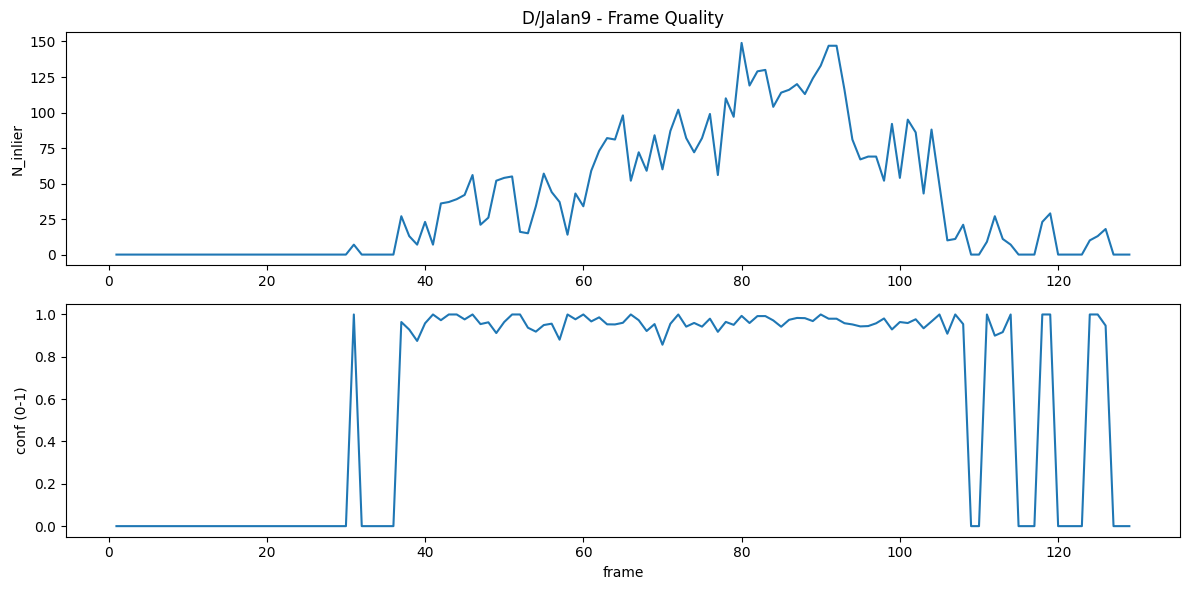

In [22]:
plot_trial_quality("D", 9)